In [2]:
import netket as nk

# Import Json, this will be needed to examine log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


In [3]:
#Basis Vectors that define the positioning of the unit cell
basis_vectors = [[0,1],[np.sqrt(3)/2,-1/2]]

#Locations of atoms within the unit cell
atom_positions = [[0,0],[np.sqrt(3)/6,1/2]]

#Number of unit cells in each direction
dimensions = [3,3]

#Define the graph
graph = nk.graph.Lattice(basis_vectors=basis_vectors,
                         atoms_coord = atom_positions,
                         extent = dimensions
                        )
symmetries = graph.automorphisms()
# Define the Hilbert space
hi = nk.hilbert.Spin(s=int(1) / int(2), N=graph.n_nodes, total_sz = int(0))

#Define the Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=graph, sign_rule=True)

#Feature dimensions of hidden layers, from first to last
feature_dims = (8,8,8,8)

#Number of layers
num_layers = 4

#Define the GCNN
ma = nk.models.GCNN(symmetries = symmetries, layers = num_layers, features = feature_dims)

# Metropois-Hastings with two spins flipped that are at most second nearest neighbors
sa = nk.sampler.MetropolisExchange(hilbert = hi, graph=graph, d_max=2)

#Stochaistic reconfiguration
op = nk.optimizer.Sgd(learning_rate=1e-2)
sr = nk.optimizer.SR(diag_shift=0.01)

#Define a variational state so we can keep the parameters if we like
vstate = nk.variational.MCState(sampler=sa, model=ma, n_samples=100)

#Define a driver that performs VMC
gs = nk.driver.VMC(ha, op, sr=sr, variational_state=vstate)

/Users/liuping/opt/anaconda3/envs/py39/lib/python3.9/site-packages/netket/graph/lattice.py:354: FutureWarning: atoms_coord is deprecated and may be removed in future versions, please use site_offsets instead
  warnings.warn(
/Users/liuping/opt/anaconda3/envs/py39/lib/python3.9/site-packages/netket/variational.py:29: FutureWarning: The `netket.variational` module is deprecated. Use `netket.vqs` instead.
To fix this warning, change `netket.variational.MCState to `netket.vqs.MCState`.
  _warn_deprecation(
/Users/liuping/opt/anaconda3/envs/py39/lib/python3.9/site-packages/netket/driver/vmc.py:86: FutureWarning: The `sr` keyword argument is deprecated in favour of `preconditioner`.Please update your code to `VMC(.., precondioner=your_sr)`
  warn_deprecation(


In [12]:
print(vstate)

MCState(hilbert = Spin(s=1/2, total_sz=0, N=18), sampler = MetropolisSampler(rule = ExchangeRule(# of clusters: 81), n_chains = 16, machine_power = 2, n_sweeps = 18, dtype = <class 'numpy.float64'>), n_samples = 112)


100%|██████████| 100/100 [03:28<00:00,  2.08s/it, Energy=-40.317 ± 0.058 [σ²=0.372, R̂=1.0086]]


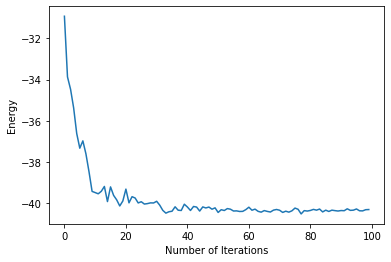

In [4]:
#Run the optimization
gs.run(n_iter=100, out='out')

#Get data from log and
energy = []
data=json.load(open("out.log"))
for en in data["Energy"]["Mean"]:
    energy.append(en)

#plot the energy during the optimization
plt.xlabel("Number of Iterations")
plt.ylabel("Energy")

plt.plot(energy)